In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten,BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

# from IPython.display import clear_output
# import warnings
# warnings.filterwarnings('ignore')

In [21]:
dir="train_data"
test_dir="test_data"

data=pd.read_csv("train_labels.csv")

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [22]:
n=len(os.listdir(dir))
print("Number of images in test and train set : ",n)

Number of images in test and train set :  8000


Number of cats vs dogs images :  4000  :  4000


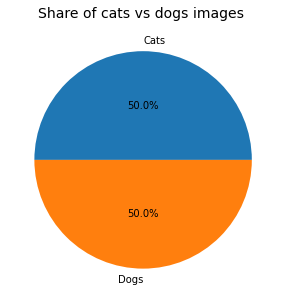

In [23]:
cats=dogs=0
for i in data["label"]:
    if i=="cat":
        cats+=1
    elif i=="dog":
        dogs+=1

plt.figure(figsize=(5, 5))
plt.pie(x=np.array([cats,dogs]), autopct="%.1f%%", labels=["Cats", "Dogs"], pctdistance=0.5)
plt.title("Share of cats vs dogs images ", fontsize=14)
print("Number of cats vs dogs images : ",cats," : ",dogs)


In [24]:
IMG_WIDTH=128
IMG_HEIGHT=128

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [25]:
# make input data into desired format


# cats_files=[]
# dogs_files=[]

# for i,label in enumerate(data["label"]):
#     if label=="cat":
#         cats_files.append(str(data["id"][i])+".png")
#     elif label=="dog":
#         dogs_files.append(str(data["id"][i])+".png")

# for f in cats_files:
#     shutil.copyfile(os.path.join(dir,f),os.path.join("train/cats",f))

# for f in dogs_files:
#     shutil.copyfile(os.path.join(dir,f),os.path.join("train/dogs",f))

In [26]:
# for test set arrangin data

# cats_files=[]
# dogs_files=[]

# test_data=pd.read_csv("test_labels.csv")

# for i,label in enumerate(test_data["label"]):
#     if label=="cat":
#         cats_files.append(str(test_data["id"][i])+".png")
#     elif label=="dog":
#         dogs_files.append(str(test_data["id"][i])+".png")

# for f in cats_files:
#     shutil.copyfile(os.path.join(test_dir,f),os.path.join("test/cats",f))

# for f in dogs_files:
#      shutil.copyfile(os.path.join(test_dir,f),os.path.join("test/dogs",f))

In [27]:
BATCH_SIZE=32

train_set=image_dataset_from_directory(
    "train",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    "train",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    "test",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.
Found 2000 files belonging to 2 classes.


In [28]:
# def transfer_learning():
#     base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
#     thr=149
#     for layers in base_model.layers[:thr]:
#         layers.trainable=False
    
#     for layers in base_model.layers[thr:]:
#         layers.trainable=True
    
#     return base_model

In [29]:
def create_model():
    model=Sequential()
    
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(2,activation='softmax'))
    
    model.summary()
    
    return model

In [30]:
model=create_model()

model.compile(optimizer="adam", 
                loss='binary_crossentropy',
                metrics = "accuracy")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                      

In [31]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.2,min_lr = 0)
callbacks = [earlystop,learning_rate_reduction]

In [32]:
EPOCHS=12

history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS,callbacks=callbacks)

Epoch 1/12
200/200 [==============================] - 178s 867ms/step - loss: 0.7295 - accuracy: 0.5870 - val_loss: 0.7001 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 2/12
200/200 [==============================] - 177s 886ms/step - loss: 0.6520 - accuracy: 0.6403 - val_loss: 0.6561 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 3/12
200/200 [==============================] - 189s 947ms/step - loss: 0.6121 - accuracy: 0.6652 - val_loss: 0.6071 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 4/12
200/200 [==============================] - 180s 902ms/step - loss: 0.5881 - accuracy: 0.6884 - val_loss: 0.5996 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 5/12
200/200 [==============================] - 179s 896ms/step - loss: 0.5521 - accuracy: 0.7286 - val_loss: 0.5981 - val_accuracy: 0.6819 - lr: 0.0010
Epoch 6/12
200/200 [==============================] - 175s 875ms/step - loss: 0.5148 - accuracy: 0.7386 - val_loss: 0.5476 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 7/12
200/200 [==========================

In [33]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

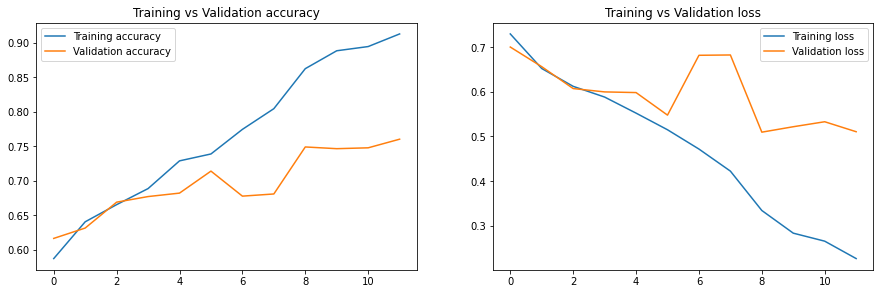

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs Validation loss")

plt.show()

In [35]:
y_pred = np.array([])
y_true =  np.array([])

for x, y in test_set:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [36]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76      1000
         1.0       0.76      0.76      0.76      1000

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



In [37]:
results = model.evaluate(test_set)

63/63 [==============================] - 16s 256ms/step - loss: 0.5349 - accuracy: 0.7610


76.10 % Test Accuracy and 76 & Validation Accuracy using 3,314,690 parameters.

In [38]:
def plot_confusion_matrix(mat, target_names, title='Confusion Matrix', cmap=None):
    accuracy = np.trace(mat) / float(np.sum(mat))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.grid('off')
    plt.show()

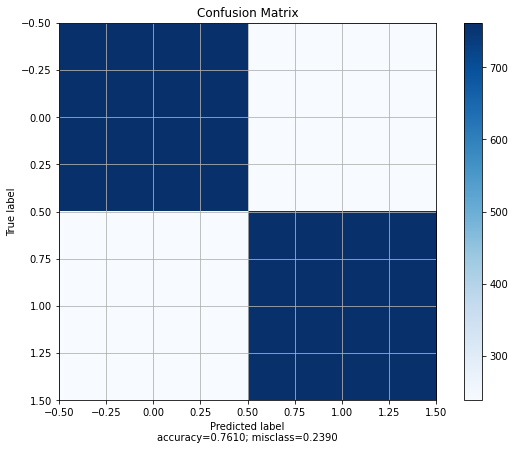

In [39]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(mat, test_set.class_names)
